## Loading the libraries

In [2]:
import pandas as pd
from nltk.corpus import stopwords
import functions
import nltk
nltk.download('stopwords')

# For plotting 
import seaborn as sns

# Model Implementation
import tensorflow as tf
import numpy as np
import xgboost as xgb
from ast import literal_eval
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from tensorflow.keras import Model
from tensorflow.keras.layers import *
import matplotlib.pyplot as plt
print(xgb.__version__)

# Used for comparing RNN and CNN
from keras.preprocessing import sequence


[nltk_data] Downloading package stopwords to /Users/adn-
[nltk_data]     mbp/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


2.1.1


## Loading the dataset

In [3]:
train_data = pd.read_csv('Dataset/train.csv')

In [4]:
train_data = train_data[:70000]

In [5]:
test_data = pd.read_csv('dataset/test.csv')

## Merging the train and test data together

In [6]:
dataset = pd.concat([train_data, test_data], axis = 0)

In [7]:
new_dataset = dataset.drop_duplicates()

In [8]:
# updating the dataset's index after removing duplicates

new_dataset.index = range(new_dataset.index.size)

In [9]:
new_dataset['Genre'].unique()

array(['Rock', 'Metal', 'Pop', 'Indie', 'R&B', 'Folk', 'Electronic',
       'Jazz', 'Hip-Hop', 'Country'], dtype=object)

In [10]:
# Storing the Music Genre Names into a variable
class_names = ['pop', 'rock', 'country', 'electronic', 'hip-hop']

In [11]:
new_dataset = new_dataset[
    (new_dataset['Genre'] == 'Hip-Hop') |
    (new_dataset['Genre'] == 'Pop') |
    (new_dataset['Genre'] == 'Country') |
    (new_dataset['Genre'] == 'Rock') |
    (new_dataset['Genre'] == 'Electronic')
]

In [12]:
new_dataset['Lyrics'] = new_dataset['Lyrics'].astype(str)

In [13]:
new_dataset['Lyrics'] = functions.clean_data(new_dataset['Lyrics'])

# Data Preprocessing

In [14]:
# Removing songs with no lyrics

new_dataset = new_dataset.drop(
    new_dataset[new_dataset['Lyrics'].str.len() == 0].index
)

In [15]:
# Grouping the data by artist and genre

new_dataset.groupby('Genre')['Song'].count()

Genre
Country         810
Electronic      755
Hip-Hop         960
Pop            8069
Rock          43009
Name: Song, dtype: int64

In [16]:
minimum_songs = min(new_dataset.groupby('Genre')['Song'].count())
minimum_songs

755

In [17]:
# Iterating over each unique genre in the 'Genre' column of the dataset
for genre in new_dataset['Genre'].unique():
    
    # Checking if the number of songs in the current genre is less than twice the minimum number of songs in any genre
    if new_dataset[new_dataset['Genre'] == genre]['Song'].size < (2 * minimum_songs):
        
        # Creating a copy of all rows in the dataset that belongs to the current genre
        data_copy = new_dataset[new_dataset['Genre'] == genre].copy()
        
        # Concatenate the copied rows back to the original dataset
        new_dataset = pd.concat([new_dataset, data_copy], axis=0)

In [18]:
# Reset the index of the DataFrame to a sequential integer range starting from 0

new_dataset.index = range(new_dataset.index.size)

In [19]:
# Iterating over each unique genre in the 'Genre' column of the dataset
for genre in new_dataset['Genre'].unique():
    
    # Find the maximum index ID of the song in the current genre that falls within the threshold of 2 * minimum_songs
    maxID = new_dataset[new_dataset['Genre'] == genre].index[2 * minimum_songs - 1]
    
    # Drop the rows where the genre matches the current genre AND the index is greater than maxID
    new_dataset = new_dataset.drop(new_dataset[(new_dataset['Genre'] == genre) & (new_dataset.index > maxID)].index)

In [20]:
new_dataset.groupby('Genre')['Song'].count()

Genre
Country       1510
Electronic    1510
Hip-Hop       1510
Pop           1510
Rock          1510
Name: Song, dtype: int64

## Tokenization and removal of unnecessary words

In [21]:
# Appling the split_data function to the 'Lyrics' column of the new_dataset DataFrame

new_dataset['Lyrics'] = functions.split_data(new_dataset['Lyrics'])

In [22]:
# Removing and storing the stop words from the lyrics column

# Importing the set of English stopwords from the NLTK library
stop_words = set(stopwords.words('english'))

# Initialize an empty list to store the processed lyrics
new_songs = []

# Iterating over each list of words in the 'Lyrics' column of the new_dataset DataFrame
for value in new_dataset['Lyrics']:
    
    # Filtering out any words in the current list that are found in the stop_words set
    value = [w for w in value if not w in stop_words]
    
    # Appending the filtered list of words to the new_songs list
    new_songs.append(value)

# Assigning the processed list of lyrics back to the 'Lyrics' column of the new_dataset DataFrame
new_dataset['Lyrics'] = new_songs

In [23]:
new_dataset = new_dataset[['Lyrics', 'Genre']]
new_dataset.head()

,Lyrics,Genre
0,"[starts, pain, , followed, hate, fueled, endle...",Rock
1,"[freedom, , alone, alone, patiently, waiting, ...",Rock
2,"[biting, hand, feeds, , lying, voice, inside, ...",Rock
3,"[say, know, cant, imagine, waits, across, line...",Rock
4,"[heart, beating, faster, cant, control, feelin...",Rock


In [24]:
# Saving the cleaned dataset to a new CSV file

new_dataset.to_csv('clean_data.csv', index = False)

# Implementing models

In [25]:
# Read the cleaned dataset from the CSV file

dataset = pd.read_csv(
    'clean_data.csv',
    converters = {
        'Lyrics': literal_eval
    }
)

In [26]:
# Storing the lyrics and genre columns in separate variables

lyrics = dataset['Lyrics']
genre = dataset['Genre']

In [27]:
# Train and test splitting the data

X_train, X_test, y_train, y_test = train_test_split(
    lyrics, genre, test_size=0.25, random_state=42, stratify = genre
)

# Storing 25% of the training data for validation purposes that is 18.75% of the original dataset
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42, stratify = y_train
)

In [28]:
# Printing the shape of the training, validation, and testing datasets

print("Shape of X_train: ", X_train.shape)
print("Shape of X_val: ", X_val.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of y_val: ", y_val.shape)
print("Shape of y_test: ", y_test.shape)

Shape of X_train:  (4246,)
Shape of X_val:  (1416,)
Shape of X_test:  (1888,)
Shape of y_train:  (4246,)
Shape of y_val:  (1416,)
Shape of y_test:  (1888,)


### Implemeting tf-idf

In [29]:
# Creating a vocabulary of the top 10,000 most frequently occurring words in the training set

stopwords = functions.create_vocab(X_train, 10000)
stopwords_len = len(stopwords)

In [30]:
# Function to calculate document frequencies for a list of words in a dataset
def create_doc_frequencies(data):
    # Initialize an empty dictionary to store document frequencies of each word
    docFrequencies = {}
    
    # Get the total number of documents (rows) in the dataset
    numDocuments = X_train.shape[0]
    
    # Iterate over each word in the stopwords list (or set)
    for word in stopwords:
        # Initialize a counter for the number of documents that contain the word
        docFrequency = 0
        
        # Iterate over each document (text) in the dataset
        for text in data:
            # If the word is present in the current document, increment the counter
            if word in text:
                docFrequency += 1
        
        # Calculate the ratio of documents containing the word and store it in the dictionary
        docFrequencies[word] = docFrequency / numDocuments
    
    # Return the dictionary containing the document frequencies
    return docFrequencies

In [31]:
# Creating doc frequency

docFrequencies = create_doc_frequencies(X_train)

In [32]:
# Function to create TF-IDF representations for the given data
def create_tf_idf(data, docFrequencies):
    # Initializing an empty list to store the TF-IDF representations
    newData = []
    
    # Converting the document frequencies dictionary into a list of values
    docFrequenciesList = list(docFrequencies.values())
    
    # Iterating over each document (list of words) in the dataset
    for text in data:
        # Initializing a bag of words representation with zeros
        bag = [0] * stopwords_len
        
        # Iterating over each word in the document
        for word in text:
            # If the word is in the stopwords list, increment its count in the bag
            if word in stopwords:
                bag[stopwords[word]] += 1
        
        # Converting the bag of words into a term frequency (TF) representation
        for i in range(len(bag)):
            bag[i] = bag[i] / len(text)  # Normalize by the total number of words in the document
            
            # Converting the term frequency (TF) into TF-IDF by multiplying by the inverse document frequency (IDF)
            bag[i] = bag[i] * np.log(1 / docFrequenciesList[i])
        
        # Append the TF-IDF vector for the current document to the newData list
        newData.append(bag)
    
    # Return the list of TF-IDF vectors
    return newData

In [33]:
# creating tf-idf vectors for training, validation, and testing datasets

X_train = create_tf_idf(X_train, docFrequencies)
X_val = create_tf_idf(X_val, docFrequencies)
X_test = create_tf_idf(X_test, docFrequencies)

In [34]:
# Converting the genre labels into numerical classes using a mapping function

y_train = y_train.apply(lambda x: functions.genre_to_class[x])
y_val = y_val.apply(lambda x: functions.genre_to_class[x])
y_test = y_test.apply(lambda x: functions.genre_to_class[x])

In [35]:
# Converting them into an array

X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

In [36]:
# Printing the shape of the training, validation, and testing datasets

print("Shape of X_train: ", X_train.shape)
print("Shape of X_val: ", X_val.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of y_val: ", y_val.shape)
print("Shape of y_test: ", y_test.shape)

Shape of X_train:  (4246, 10000)
Shape of X_val:  (1416, 10000)
Shape of X_test:  (1888, 10000)
Shape of y_train:  (4246,)
Shape of y_val:  (1416,)
Shape of y_test:  (1888,)


## Implementing Deep Neural Network Model Algorithm

In [37]:
# Model Deep Neural Network Model code

def func_model():
    # Define the input layer with a shape corresponding to the length of the stopwords list
    input_layer = Input(shape=(stopwords_len,))
    
    # Flatten the input layer to convert the input into a 1D tensor
    flatten = Flatten()(input_layer)
    
    # First dense layer with 1024 units and ReLU activation function
    dense1 = Dense(1024, activation='relu')(flatten)
    
    # Apply dropout to the first dense layer output to prevent overfitting
    dropout1 = Dropout(rate=0.2)(dense1)
    
    # Second dense layer with 1024 units and ReLU activation
    dense2 = Dense(1024, activation='relu')(dropout1)
    
    # Apply dropout to the second dense layer output to prevent overfitting
    dropout2 = Dropout(rate=0.2)(dense2)
    
    # Concatenate the outputs of the two dense layers and their respective dropout layers
    concat = Concatenate()([dense1, dense2, dropout1, dropout2])
    
    # Define the output layer with 5 units (for 5 classes) and softmax activation
    output_layer = Dense(5, activation='softmax')(concat)
    
    # Create the model with the defined input and output layers
    model = Model(inputs=input_layer, outputs=output_layer)
    
    # Return the constructed model
    return model

In [38]:
# creating the model

model_DNN = func_model()

In [39]:
# Printing the model summary

model_DNN.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 10000)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 10000)     │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1024)      │ 10,241,024 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 1024)      │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1024)      │  1,049,600 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 1024)      │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 4096)      │          0 │ dense[0][0],      │
│ (Concatenate)       │                   │            │ dense_1[0][0],    │
│                     │                   │            │ dropout[0][0],    │
│                     │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 5)         │     20,485 │ concatenate[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 11,311,109 (43.15 MB)

 Trainable params: 11,311,109 (43.15 MB)

 Non-trainable params: 0 (0.00 B)

In [40]:
# using model checkpoint to save the best model

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='model_checkpoint_DNN.keras',  # Path to save the model file with .keras extension
    monitor='val_loss',                 # Metric to monitor
    verbose=1,                          # Verbosity mode (0 or 1)
    save_best_only=True,                # Only save the best model
    mode='min',                         # Mode for the monitored metric
    save_weights_only=False,            # Whether to save only the model weights
    save_freq='epoch'                   # Save every epoch
)

In [41]:
# Compiling the model

model_DNN.compile(
    optimizer='adam',                       # Optimizer: 'adam' is an adaptive learning rate optimization algorithm
    loss='sparse_categorical_crossentropy', # Loss function: suitable for multi-class classification with integer labels
    metrics=['accuracy']                    # Metrics: the model's performance will be evaluated based on accuracy
)

In [42]:
# Train the model 

history = model_DNN.fit(
    X_train,               # Training data features
    y_train,               # Training data labels
    epochs=10,             # Number of epochs (complete passes through the training data)
    batch_size=256,        # Number of samples per gradient update (mini-batch size)
    validation_data=(X_val, y_val),  # Validation data and labels for evaluating the model after each epoch
    verbose=1,             # Verbosity mode (1 = progress bar, 0 = silent, 2 = one line per epoch)
    callbacks=[checkpoint] # List of callback functions to apply during training (e.g., saving model checkpoints)
)

Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.2661 - loss: 1.5811
Epoch 1: val_loss improved from inf to 1.33073, saving model to model_checkpoint_DNN.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.2698 - loss: 1.5785 - val_accuracy: 0.5636 - val_loss: 1.3307
Epoch 2/10
16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.7593 - loss: 1.0549
Epoch 2: val_loss improved from 1.33073 to 0.88964, saving model to model_checkpoint_DNN.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.7614 - loss: 1.0368 - val_accuracy: 0.6624 - val_loss: 0.8896
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9113 - loss: 0.3438
Epoch 3: val_loss did not improve from 0.88964
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.9119 - loss: 0.3410 - val_accuracy: 0.6758 - val_loss: 0.9593
Epoch 4/10
16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9819 - loss: 0.0815
Epoch 4: val_loss did not improve from 0.88964
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 53

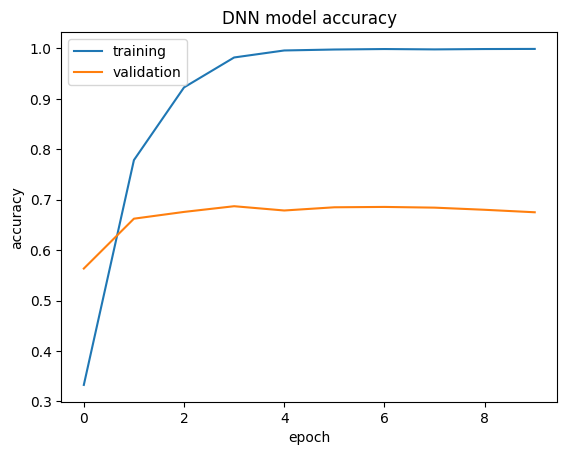

In [43]:
# Plotting the model stats

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('DNN model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

In [44]:
# Loading the best model checkpoint

model_DNN.load_weights('model_checkpoint_DNN.keras')

In [45]:
# Function to predict the genre of given songs
def predict_genre(model, songs):
    # Cleaning the songs' lyrics
    songs = functions.clean_data(songs)
    
    # Splitting the cleaned lyrics into individual words
    songs = functions.split_data(songs)
    
    # Stemming the words to reduce them to their root forms
    songs = functions.stem(songs)
    
    # Removing common stopwords from the lyrics
    songs = functions.remove_stopwords(songs)
    
    # Converting the processed lyrics into TF-IDF vectors using the document frequencies
    songs = create_tf_idf(songs, docFrequencies)
    
    # Converting the TF-IDF vectors into a NumPy array
    songs = np.array(songs)
    
    # Using the trained model to predict the genre of the songs and returning it
    return model.predict(songs)

In [46]:
# Storing the song lyrics in a variable

song_lyrics = ['Man, whatever\nDre, just let it run\nAyo, turn the beat up a little bit\nAyo, this song is for anyone...\nFuck it, just shut up and listen, ayo\nI sit back with this pack of Zig-Zags and this bag\nOf this weed, it gives me the shit needed to be\nThe most meanest MC on this on this Earth\nAnd since birth I\'ve been cursed with this curse to just curse\nAnd just blurt this berserk and bizarre shit that works\nAnd it sells and it helps in itself to relieve all this tension\nDispensing these sentences, getting this stress\nThat\'s been eating me recently off of this chest\nAnd I rest again peacefully\nBut at least have the decency in you\nTo leave me alone, when you freaks see me out\nIn the streets when I\'m eating or feeding my daughter\nTo not come and speak to me\nI don\'t know you, and no, I don\'t owe you a mothafuckin\' thing\nI\'m not Mr. N\'Sync, I\'m not what your friends think\nI\'m not Mr. Friendly, I can be a prick if you tempt me\nMy tank is on empty, no patience is in me\nAnd if you offend me, I\'m lifting you ten feet in the air\nI don\'t care who was there and who saw me just jaw you\nGo call you a lawyer, file you a lawsuit\nI\'ll smile in the courtroom and buy you a wardrobe\nI\'m tired of all you, I don\'t mean to be mean\nBut that\'s all I can be, it\'s just me\nAnd I am whatever you say I am\nIf I wasn\'t, then why would I say I am?\nIn the paper, the news, every day I am\nRadio won\'t even play my jam\n\'Cause I am whatever you say I am\nIf I wasn\'t, then why would I say I am?\nIn the paper, the news, every day I am, huh\nI don\'t know, it\'s just the way I am\nSometimes I just feel like my father\nI hate to be bothered with all of this nonsense, it\'s constant\nAnd, oh, it\'s his lyrical content, the song Guilty Conscience\nHas gotten such rotten responses\nAnd all of this controversy circles me\nAnd it seems like the media immediately points a finger at me\nSo I point one back at \'em, but not the index or pinkie\nOr the ring or the thumb, it\'s the one you put up\nWhen you don\'t give a fuck, when you won\'t just put up\nWith the bullshit they pull, \'cause they full of shit too\nWhen a dude\'s getting bullied and shoots up his school\nAnd they blame it on Marilyn and the heroin\nWhere were the parents at? And look where it\'s at!\nMiddle America, now it\'s a tragedy\nNow it\'s so sad to see, an upper-class city\nHavin\' this happenin\'\nThen attack Eminem \'cause I rap this way\nBut I\'m glad, \'cause they feed me the fuel that I need\nFor the fire to burn and it\'s burning, and I have returned\nAnd I am whatever you say I am\nIf I wasn\'t, then why would I say I am?\nIn the paper, the news, every day I am\nRadio won\'t even play my jam\n\'Cause I am whatever you say I am\nIf I wasn\'t, then why would I say I am?\nIn the paper, the news, every day I am\nI don\'t know, it\'s just the way I am\nI\'m so sick and tired of being admired\nThat I wish that I would just die or get fired\nAnd dropped from my label, let\'s stop with the fables\nI\'m not gonna be able to top on "My Name Is"\nAnd pigeon-holed into some poppy sensation\nTo cop me rotation at rock-n-roll stations\nAnd I just do not got the patience\nTo deal with these cocky Caucasians\nWho think I\'m some wigger who just tries to be black\n\'Cause I talk with an accent, and grab on my balls\nSo they always keep asking the same fucking questions\nWhat school did I go to, what hood I grew up in\nThe why, the who, what, when, the where and the how\n\'Til I\'m grabbing my hair and I\'m tearin\' it out\n\'Cause they driving me crazy, I can\'t take it\nI\'m racin\', I\'m pacin\', I stand and I sit\nAnd I\'m thankful for every fan that I get\nBut I can\'t take a shit in the bathroom\nWithout someone standing by it\nNo, I won\'t sign you an autograph\nYou can call me an asshole, I\'m glad, \'cause...\nI am whatever you say I am\nIf I wasn\'t, then why would I say I am?\nIn the paper, the news, every day I am\nRadio won\'t even play my jam\n\'Cause I am whatever you say I am\nIf I wasn\'t, then why would I say I am?\nIn the paper, the news, every day I am\nI don\'t know, it\'s just the way I am']

In [47]:
# passing the song along with the model to check the model prediction

predict_genre(model_DNN, song_lyrics)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


array([[0.21659428, 0.33637974, 0.01728611, 0.08723298, 0.34250686]],
      dtype=float32)

In [48]:
# Make predictions on the test set using the trained model
y_pred = model_DNN.predict(X_test)

# Convert the predicted probabilities into class labels
y_pred_classes = np.argmax(y_pred, axis=1)

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [49]:
# Calculate and storing the DNN model accuracy and loss

dnn_loss, dnn_accuracy = model_DNN.evaluate(X_test, y_test)

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6544 - loss: 0.8924


In [50]:
# Generate the confusion matrix

conf_matrix = confusion_matrix(y_test, y_pred_classes)

In [53]:
# Calculate differnt metrics to check the model performance


precision = precision_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')
f1 = f1_score(y_test, y_pred_classes, average='weighted')
mcc = matthews_corrcoef(y_test, y_pred_classes)
kappa = cohen_kappa_score(y_test, y_pred_classes)# For regression predictions
rmse = np.sqrt(mean_squared_error(y_test, y_pred_classes))
rss = np.sum(np.square(y_test - y_pred_classes))
mape = mean_absolute_percentage_error(y_test, y_pred_classes)

# Calculate Sensitivity and Specificity
tp = conf_matrix[1, 1]  # True Positives
tn = conf_matrix[0, 0]  # True Negatives
fp = conf_matrix[0, 1]  # False Positives
fn = conf_matrix[1, 0]  # False Negatives

sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

In [54]:
# Storing the DNN model stats in a dictionary

dnn_stats = {
    'Accuracy': dnn_accuracy * 100,
    'Loss': dnn_loss * 100,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Matthews Correlation Coefficient': mcc,
    'Cohen\'s Kappa': kappa,
    'RMSE': rmse,
    'RSS': rss,
    'MAPE': mape,
    'Sensitivity': sensitivity,
    'Specificity': specificity
}

In [55]:
# Print additional metrics
print("Deep Neural Network Model \n---------------------------")
print(f"Accuracy: {dnn_accuracy * 100:.2f}%")
print(f"Loss: {dnn_loss * 100:.2f}%")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"Matthews Correlation Coefficient: {mcc:.2f}")
print(f"Cohen's Kappa: {kappa:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"RSS: {rss:.2f}")
print(f"MAPE: {mape:.2f}")
print(f"Sensitivity (Recall): {sensitivity:.2f}")
print(f"Specificity: {specificity:.2f}")

Deep Neural Network Model 
---------------------------
Accuracy: 65.57%
Loss: 88.61%
Precision: 0.66
Recall: 0.66
F1-Score: 0.65
Matthews Correlation Coefficient: 0.57
Cohen's Kappa: 0.57
RMSE: 1.13
RSS: 2416.00
MAPE: 889747172144700.75
Sensitivity (Recall): 0.69
Specificity: 0.58


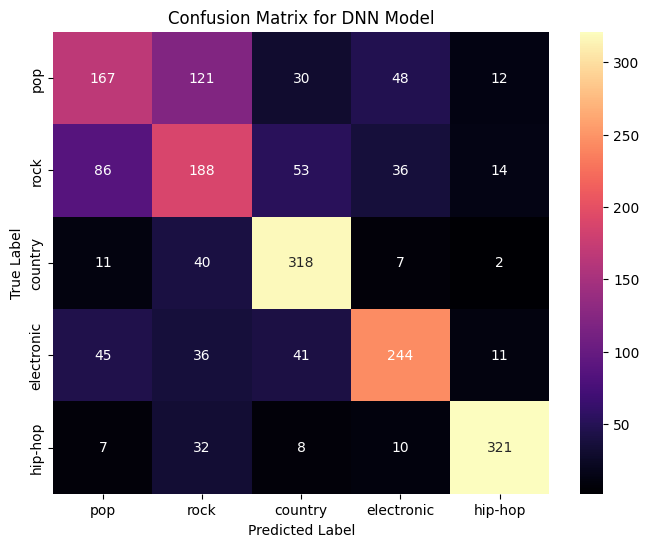

In [56]:
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='magma', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix for DNN Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [57]:
# Classification Report
class_report = classification_report(y_test, y_pred_classes)
print("\nClassification Report:")
print(class_report)


Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.44      0.48       378
           1       0.45      0.50      0.47       377
           2       0.71      0.84      0.77       378
           3       0.71      0.65      0.68       377
           4       0.89      0.85      0.87       378

    accuracy                           0.66      1888
   macro avg       0.66      0.66      0.65      1888
weighted avg       0.66      0.66      0.65      1888



## Implementing XGBoost Model

In [58]:
# Creating an instance of the XGBoost classifier
modelXGB = xgb.XGBClassifier(
    use_label_encoder=False,  # Disables the use of the label encoder, which was deprecated in recent versions
    eval_metric='mlogloss'    # Seting the evaluation metric to multi-class log loss (cross-entropy loss)
)

# Training the XGBoost model using the training data
modelXGB.fit(X_train, y_train)

/opt/anaconda3/envs/Machine_Learning/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [13:13:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [59]:
# Predict on the test set
y_pred = modelXGB.predict(X_test)

# Calculate accuracy
xgb_accuracy = accuracy_score(y_test, y_pred)

# Make sure to predict probabilities if calculating log loss
y_pred_proba = modelXGB.predict_proba(X_test)

# Calculate log loss, assuming y_test is properly formatted for a classification problem
xgb_loss = log_loss(y_test, y_pred_proba)

In [60]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
tp = conf_matrix[1, 1]  # True Positive
fn = conf_matrix[1, 0]  # False Negative
tn = conf_matrix[0, 0]  # True Negative
fp = conf_matrix[0, 1]  # False Positive

# Sensitivity (Recall or True Positive Rate)
sensitivity = tp / (tp + fn)

# Specificity (True Negative Rate)
specificity = tn / (tn + fp)

In [61]:
# Storing the XGBoost model stats in a dictionary

xgb_stats = {
    'Accuracy': xgb_accuracy * 100,
    'Loss': xgb_loss * 100,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Matthews Correlation Coefficient': mcc,
    'Cohen\'s Kappa': kappa,
    'RMSE': rmse,
    'RSS': rss,
    'MAPE': mape,
    'Sensitivity': sensitivity,
    'Specificity': specificity
}

In [62]:
# Printing the results of the XGBoost model

print("XGBoost Model \n------------------------------------")
print(f"Accuracy: {xgb_accuracy * 100:.2f}%")
print(f"Log Loss: {xgb_loss:.4f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"Matthews Correlation Coefficient: {mcc:.2f}")
print(f"Cohen's Kappa: {kappa:.2f}")
print(f"RMSE: {rmse}")
print(f"RSS: {rss}")
print(f"MAPE: {mape}")
print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {specificity}")

XGBoost Model 
------------------------------------
Accuracy: 69.23%
Log Loss: 0.8214
Precision: 0.66
Recall: 0.66
F1-Score: 0.65
Matthews Correlation Coefficient: 0.57
Cohen's Kappa: 0.57
RMSE: 1.1312210292198217
RSS: 2416
MAPE: 889747172144700.8
Sensitivity: 0.7228070175438597
Specificity: 0.6573426573426573


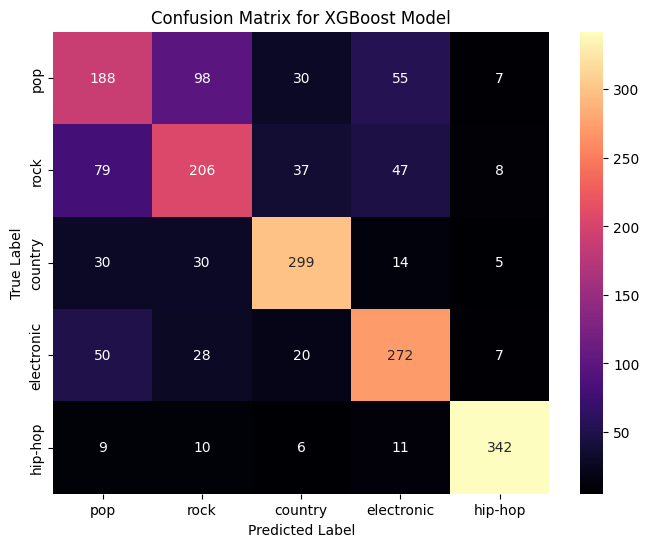

In [63]:
# Plot Confusion Matrix as a Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='magma', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix for XGBoost Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [64]:
# Classification Report
class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.50      0.51       378
           1       0.55      0.55      0.55       377
           2       0.76      0.79      0.78       378
           3       0.68      0.72      0.70       377
           4       0.93      0.90      0.92       378

    accuracy                           0.69      1888
   macro avg       0.69      0.69      0.69      1888
weighted avg       0.69      0.69      0.69      1888



## Implementing Recurrent Neural Network Model

In [65]:
# Performing train, test and validation split of the data

X_train, X_test, y_train, y_test = train_test_split(
    lyrics, genre, test_size=0.25, random_state=42, stratify = genre
)


# Storing 25% of the training data for validation purposes that is 18.75% of the original dataset

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42, stratify = y_train
)

In [66]:
# Creating a vocabulary from the training data using a custom function
vocab = functions.create_vocab(X_train)

# Calculate the size of the vocabulary (i.e., the number of unique words)
vocabSize = len(vocab)

In [67]:
# Function to convert words in the data into integer-encoded representations
def integer_encoding(data):
    newData = []  # Initialize an empty list to store the integer-encoded data
    
    for text in data:  # Iterate over each document (list of words) in the dataset
        newText = []  # Initialize a list to store the integer-encoded version of the current document
        
        for word in text:  # Iterate over each word in the current document
            if word not in vocab:
                newText.append(1)  # If the word is not in the vocabulary, append 1
            if word in vocab and vocab[word] > 0:  # Ensure the word is in the vocabulary and not an "empty" word
                newText.append(vocab[word] + 1)  # Add 1 to the vocabulary index to avoid using 0
        
        newData.append(newText)  # Append the integer-encoded document to the newData list
    
    return newData  # Return the list of integer-encoded documents

In [68]:
# Performing integer-encoding on the training, validation, and testing datasets

X_train = integer_encoding(X_train)
X_val = integer_encoding(X_val)
X_test = integer_encoding(X_test)

In [69]:
# Converting the genre labels into numerical classes using a mapping function

y_train = y_train.apply(lambda x: functions.genre_to_class[x])
y_val = y_val.apply(lambda x: functions.genre_to_class[x])
y_test = y_test.apply(lambda x: functions.genre_to_class[x])

### Padding

In [70]:
# Function to calculate the maximum length of documents in the dataset
def max_len(data):
    maxLen = 0  # Initialize a variable to keep track of the maximum length
    
    # Iterate over each document (list of words) in the dataset
    for text in data:
        # If the current document's length is greater than maxLen, update maxLen
        if len(text) > maxLen:
            maxLen = len(text)
    
    return maxLen  # Return the maximum length found

In [71]:
# Calculating the maximum length of sequences in the training data

maxLen = max_len(X_train)

In [72]:
# Pad the sequences in the training, validation, and test datasets to ensure they all have the same length

X_train = sequence.pad_sequences(X_train, maxlen=maxLen)
X_val = sequence.pad_sequences(X_val, maxlen=maxLen)
X_test = sequence.pad_sequences(X_test, maxlen=maxLen)

### Building the model

In [73]:
# Recurrent Neural Network Model function
def func_model():
    # Input layer to accept sequences of variable length (None) with integer values (word indices)
    input_layer = Input(shape=(None,), dtype="int64")
    
    # Embedding layer to convert integer-encoded words into dense vectors
    embedding = Embedding(vocabSize + 1, 64)(input_layer)
    
    # LSTM layer to process the embedded sequences and capture sequential dependencies
    lstm = LSTM(64)(embedding)
    
    # Dense layer with softmax activation to output class probabilities
    output_layer = Dense(5, activation="softmax")(lstm)
    
    # Define the model by specifying the input and output layers
    model = Model(inputs=input_layer, outputs=output_layer)
    
    # Return the constructed model
    return model

In [74]:
# Creating the RNN model

model_RNN = func_model()

In [75]:
# Printing the model summary

model_RNN.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, None, 64)       │     1,927,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,961,221 (7.48 MB)

 Trainable params: 1,961,221 (7.48 MB)

 Non-trainable params: 0 (0.00 B)

In [76]:
# creating checkpoint to save the best model

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='model_checkpoint_RNN.keras',  # Path to save the model file with .keras extension
    monitor='val_accuracy',                 # Metric to monitor
    save_best_only=True,                # Only save the best model
    save_weights_only=False,            # Whether to save only the model weights
)

In [77]:
# Compiling the RNN model

model_RNN.compile(
    loss="sparse_categorical_crossentropy",  # Loss function: suitable for multi-class classification with integer labels
    optimizer="rmsprop",                     # Optimizer: RMSprop is an adaptive learning rate optimizer
    metrics=['accuracy']                     # Metrics: the model's performance will be evaluated based on accuracy
)

In [78]:
# Train the RNN model using
history = model_RNN.fit(
    X_train,               # Training data features (padded sequences)
    y_train,               # Training data labels (integer-encoded class labels)
    epochs=10,             # Number of epochs (complete passes through the training data)
    batch_size=256,        # Number of samples per gradient update (mini-batch size)
    validation_data=(X_val, y_val),  # Validation data and labels for evaluating the model after each epoch
    verbose=1,             # Verbosity mode (1 = progress bar, 0 = silent, 2 = one line per epoch)
    callbacks=[checkpoint] # List of callback functions to apply during training (e.g., saving model checkpoints)
)

Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.2036 - loss: 1.6092 - val_accuracy: 0.2641 - val_loss: 1.6077
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.2873 - loss: 1.6044 - val_accuracy: 0.2790 - val_loss: 1.6019
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.3182 - loss: 1.5703 - val_accuracy: 0.2712 - val_loss: 1.5161
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.3715 - loss: 1.3809 - val_accuracy: 0.4195 - val_loss: 1.3647
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.4417 - loss: 1.2979 - val_accuracy: 0.4244 - val_loss: 1.3203
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.4744 - loss: 1.2296 - val_accuracy: 0.4428 - val_loss: 1.2909
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.5037 - loss: 1.1574 - val_accuracy: 0.4696 - val_loss: 1.3537
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.5380 - loss: 1.1042 - val_accuracy: 0.4682 - val_loss:

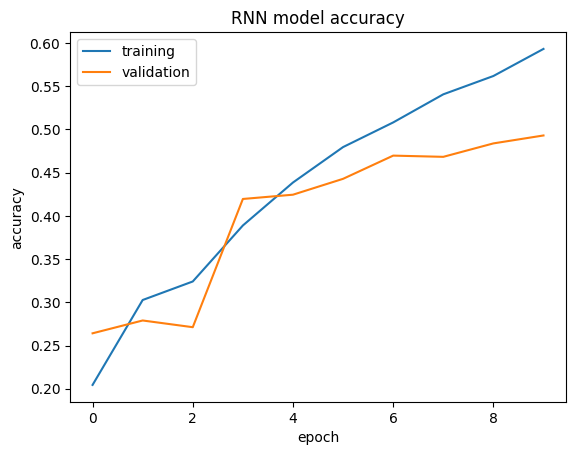

In [79]:
# Printing the model stats

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('RNN model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

In [80]:
# Function to predict the genre of given songs using a trained model
def predict_genre(model, songs):
    # Clean the songs' lyrics
    songs = functions.clean_data(songs)
    
    # Splitting the cleaned lyrics into individual words
    songs = functions.split_data(songs)
    
    # Stemming the words to reduce them to their root forms
    songs = functions.stem(songs)
    
    # Removing common stopwords from the lyrics
    songs = functions.remove_stopwords(songs)
    
    # Converting the processed lyrics into integer-encoded sequences using the vocabulary
    songs = integer_encoding(songs)
    
    # Padding the sequences to ensure they all have the same length (maxLen)
    songs = sequence.pad_sequences(songs, maxlen=maxLen)
    
    # Using the trained model to predict the genre of the songs
    return model.predict(songs)

In [81]:
# Predicting the genre of the song

predict_genre(model_RNN, song_lyrics)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


array([[0.00343686, 0.00851131, 0.00500677, 0.00754544, 0.97549963]],
      dtype=float32)

In [82]:
# Make predictions on the test set using the trained RNN model
y_pred_prob = model_RNN.predict(X_test)

# Convert the predicted probabilities into class labels by selecting the index with the highest probability
y_pred = np.argmax(y_pred_prob, axis=1)

59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step


In [83]:
# Convert y_test to a DataFrame with a column named 'Genre'
y_test_df = pd.DataFrame(y_test, columns=['Genre'])

# Perform one-hot encoding on the 'Genre' column
y_test_one_hot = pd.get_dummies(y_test_df, columns=['Genre'])

# Get the class names by finding the index of the maximum value in the one-hot encoded array
y_test_classes = np.argmax(y_test_one_hot.values, axis=1)

In [84]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred)

In [85]:
# Calculate the Matthews Correlation Coefficient (MCC)
mcc = matthews_corrcoef(y_test, y_pred_classes)

# Calculate Cohen's Kappa score
kappa = cohen_kappa_score(y_test, y_pred_classes)

if len(y_pred_proba.shape) == 1 or y_pred_proba.shape[1] == 1:
    y_pred_positive_proba = y_pred_proba.flatten()  # Ensure it's a 1D array
else:
    # Assume the second column corresponds to the positive class probabilities
    y_pred_positive_proba = y_pred_proba[:, 1]  # This is typical for softmax with two outputs

In [86]:
# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_positive_proba))

# Calculate Residual Sum of Squares (RSS)
rss = np.sum(np.square(y_test - y_pred_positive_proba))

# Calculate Mean Absolute Percentage Error (MAPE)
mape = mean_absolute_percentage_error(y_test, y_pred_positive_proba)

# Evaluate the model on the test set to get loss and accuracy
rnn_loss, rnn_accuracy = model_RNN.evaluate(X_test, y_test)

# Calculate precision, recall, and F1-score
precision = precision_score(y_test_classes, y_pred, average='weighted')
recall = recall_score(y_test_classes, y_pred, average='weighted')
f1 = f1_score(y_test_classes, y_pred, average='weighted')

59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - accuracy: 0.5148 - loss: 1.1637


In [87]:
# Storing the model stats in a dictionary

rnn_stats = {
    'Accuracy': rnn_accuracy * 100,
    'Loss': rnn_loss * 100,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Matthews Correlation Coefficient': mcc,
    'Cohen\'s Kappa': kappa,
    'RMSE': rmse,
    'RSS': rss,
    'MAPE': mape,
    'Sensitivity': sensitivity,
    'Specificity': specificity
}

In [88]:
# Printing the results of the RNN model

print(f"RNN Model \n---------------------------")
print(f"Accuracy: {rnn_accuracy * 100:.2f}%")
print(f"Loss: {rnn_loss * 100:.2f}%")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-Score: {f1:.3f}")
print(f"Matthew's Correlation Coefficient (MCC): {mcc:.3f}")
print(f"Cohen's Kappa: {kappa:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"RSS: {rss:.3f}")
print(f"MAPE: {mape:.3f}")

RNN Model 
---------------------------
Accuracy: 49.79%
Loss: 117.72%
Precision: 0.473
Recall: 0.498
F1-Score: 0.456
Matthew's Correlation Coefficient (MCC): 0.571
Cohen's Kappa: 0.570
RMSE: 2.361
RSS: 10525.010
MAPE: 245617597577598.500


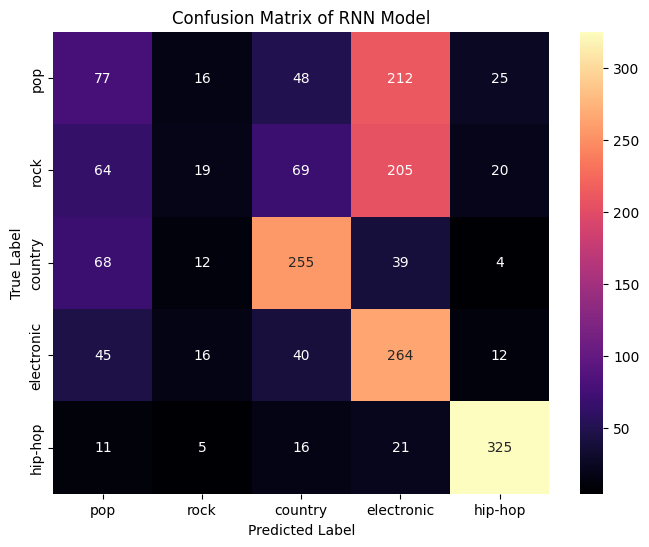

In [89]:
# Plot Confusion Matrix as a Heatmap

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='magma', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix of RNN Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [90]:
# Classification Report

class_report = classification_report(y_test_classes, y_pred)
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

           0       0.29      0.20      0.24       378
           1       0.28      0.05      0.09       377
           2       0.60      0.67      0.63       378
           3       0.36      0.70      0.47       377
           4       0.84      0.86      0.85       378

    accuracy                           0.50      1888
   macro avg       0.47      0.50      0.46      1888
weighted avg       0.47      0.50      0.46      1888



## Implementing Convolutional Neural Network Model

In [91]:
# Function to define a CNN model
def func_model():
    # Input layer
    input_layer = Input(shape=(None,), dtype="int64")
    
    # Embedding layer to convert integer-encoded words into dense vectors
    embedding = Embedding(vocabSize + 1, 64)(input_layer)
    
    # First Conv1D layer with 128 filters and a kernel size of 5, with relu acitvation function
    conv1 = Conv1D(128, 5, activation="relu")(embedding)
    
    # First MaxPooling layer with a pool size of 5
    pool1 = MaxPooling1D(5)(conv1)
    
    # Second Conv1D layer with 128 filters and a kernel size of 5
    conv2 = Conv1D(128, 5, activation="relu")(pool1)
    
    # Second MaxPooling layer with a pool size of 5
    pool2 = MaxPooling1D(5)(conv2)
    
    # Third Conv1D layer with 128 filters and a kernel size of 5
    conv3 = Conv1D(128, 5, activation="relu")(pool2)
    
    # Global max pooling layer to reduce the dimensionality by taking the maximum value over time
    g_pool = GlobalMaxPooling1D()(conv3)
    
    # Fully connected (dense) layer with 128 units and ReLU activation
    dense1 = Dense(128, activation="relu")(g_pool)
    
    # Dropout layer to prevent overfitting, with a dropout rate of 0.2
    dropout = Dropout(0.2)(dense1)
    
    # Output layer with 5 units (for 5 classes) and softmax activation to output class probabilities
    output_layer = Dense(5, activation="softmax")(dropout)
    
    # Define the model by specifying the input and output layers
    model = Model(inputs=input_layer, outputs=output_layer)
    
    # Return the constructed model
    return model

In [92]:
# Creating the CNN model

model_CNN = func_model()

In [93]:
# Printing the model summary

model_CNN.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, None, 64)       │     1,927,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, None, 128)      │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, None, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, None, 128)      │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, None, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, None, 128)      │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,150,213 (8.20 MB)

 Trainable params: 2,150,213 (8.20 MB)

 Non-trainable params: 0 (0.00 B)

In [94]:
# Saving the checkpoint to save the best model

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='model_checkpoint_CNN.keras',  # Path to save the model file with .keras extension
    monitor='val_loss',                 # Metric to monitor
    verbose=1,                          # Verbosity mode (0 or 1)
    save_best_only=True,                # Only save the best model
    mode='min',                         # Mode for the monitored metric
    save_weights_only=False,            # Whether to save only the model weights
    save_freq='epoch'                   # Save every epoch
)

In [95]:
# Compiling the CNN Model

model_CNN.compile(
    optimizer='rmsprop',                    # Optimizer: RMSprop is an adaptive learning rate optimizer
    loss='sparse_categorical_crossentropy', # Loss function: suitable for multi-class classification with integer labels
    metrics=['accuracy']                    # Metrics: the model's performance will be evaluated based on accuracy
)

In [96]:
# Train the CNN model using the training data and validate it using the validation data

history = model_CNN.fit(
    X_train,               # Training data features (input sequences)
    y_train,               # Training data labels (integer-encoded class labels)
    epochs=20,             # Number of epochs (complete passes through the training data)
    batch_size=256,        # Number of samples per gradient update (mini-batch size)
    validation_data=(X_val, y_val),  # Validation data and labels for evaluating the model after each epoch
    verbose=1,             # Verbosity mode (1 = progress bar, 0 = silent, 2 = one line per epoch)
    callbacks=[checkpoint] # List of callback functions to apply during training (e.g., saving model checkpoints)
)

Epoch 1/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 544ms/step - accuracy: 0.2512 - loss: 1.5810
Epoch 1: val_loss improved from inf to 1.46924, saving model to model_checkpoint_CNN.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 596ms/step - accuracy: 0.2522 - loss: 1.5800 - val_accuracy: 0.3270 - val_loss: 1.4692
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 505ms/step - accuracy: 0.3462 - loss: 1.4686
Epoch 2: val_loss improved from 1.46924 to 1.44294, saving model to model_checkpoint_CNN.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 556ms/step - accuracy: 0.3462 - loss: 1.4674 - val_accuracy: 0.3136 - val_loss: 1.4429
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - accuracy: 0.3661 - loss: 1.3702
Epoch 3: val_loss improved from 1.44294 to 1.35755, saving model to model_checkpoint_CNN.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 554ms/step - accuracy: 0.3667 - loss: 1.3685 - val_accuracy: 0.3750 - val_loss: 1.3576
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - accuracy: 0.3710 - loss: 1.3400
Epoch 4: val_loss impro

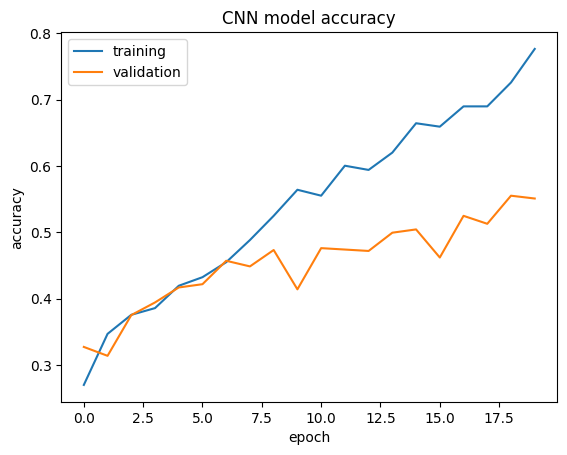

In [97]:
# Printing the model stats

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('CNN model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

In [98]:
# Loading the model weights from the best checkpoint

model_CNN.load_weights('model_checkpoint_CNN.keras')

In [99]:
# Predicting the song genre using lyrics

predict_genre(model_CNN, song_lyrics)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


array([[9.9129658e-03, 1.8561718e-01, 3.5607550e-04, 5.6462236e-02,
        7.4765152e-01]], dtype=float32)

In [100]:
# Predict class probabilities
y_pred_proba = model_CNN.predict(X_test)

# Convert probabilities to class labels
y_pred_classes = np.argmax(y_pred_proba, axis=1)

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


In [101]:
# Storing the loss and the accuracy of the model
cnn_loss, cnn_accuracy = model_CNN.evaluate(X_test, y_test)

# Calculate additional metrics
precision = precision_score(y_test_classes, y_pred, average='weighted')
recall = recall_score(y_test_classes, y_pred, average='weighted')
f1 = f1_score(y_test_classes, y_pred, average='weighted')

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred)

# Precision Score
precision = precision_score(y_test, y_pred_classes, average='weighted')

# Recall Score
recall = recall_score(y_test, y_pred_classes, average='weighted')

# F1 Score
f1 = f1_score(y_test, y_pred_classes, average='weighted')
mcc = matthews_corrcoef(y_test, y_pred_classes)

# Cohen's Kappa
kappa = cohen_kappa_score(y_test, y_pred_classes)

rmse = np.sqrt(mean_squared_error(y_test, y_pred_positive_proba))
rss = np.sum(np.square(y_test - y_pred_positive_proba))
mape = mean_absolute_percentage_error(y_test, y_pred_positive_proba)

# Extract TP, TN, FP, FN
TP = conf_matrix[1, 1]  # True Positive: correctly predicted event values
TN = conf_matrix[0, 0]  # True Negative: correctly predicted no-event values
FP = conf_matrix[0, 1]  # False Positive: incorrectly predicted event values
FN = conf_matrix[1, 0]  # False Negative: incorrectly predicted no-event values

# Calculate Sensitivity (Recall or True Positive Rate)
sensitivity = TP / float(TP + FN)

# Calculate Specificity (True Negative Rate)
specificity = TN / float(TN + FP)

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.4389 - loss: 1.2635


In [102]:
# Store the CNN model stats in a dictionary

cnn_stats = {
    'Accuracy': cnn_accuracy * 100,
    'Loss': cnn_loss * 100,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Matthews Correlation Coefficient': mcc,
    'Cohen\'s Kappa': kappa,
    'RMSE': rmse,
    'RSS': rss,
    'MAPE': mape,
    'Sensitivity': sensitivity,
    'Specificity': specificity
}

In [103]:
# Printing the CNN model statistics

print(f"CNN Model \n--------------------------------")
print(f"Accuracy: {cnn_accuracy * 100:.2f}%")
print(f"Loss: {cnn_loss * 100:.2f}%")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.3f}")
print(f"F1-Score: {f1:.3f}")
print(f"Matthew's Correlation Coefficient: {mcc:.3f}")
print(f"Cohen's Kappa: {kappa:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"RSS: {rss:.3f}")
print(f"MAPE: {mape:.3f}")
print(f"Sensitivity (Recall or True Positive Rate): {sensitivity:.3f}")
print(f"Specificity (True Negative Rate): {specificity:.3f}")

CNN Model 
--------------------------------
Accuracy: 44.92%
Loss: 125.58%
Precision: 0.46
Recall: 0.449
F1-Score: 0.455
Matthew's Correlation Coefficient: 0.312
Cohen's Kappa: 0.311
RMSE: 2.361
RSS: 10525.010
MAPE: 245617597577598.500
Sensitivity (Recall or True Positive Rate): 0.229
Specificity (True Negative Rate): 0.828


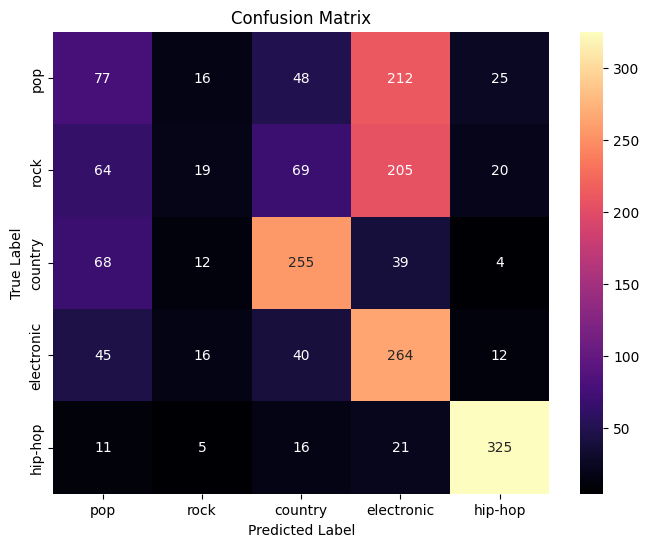

In [104]:
# Plot Confusion Matrix as a Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='magma', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [105]:
# Classification Report
class_report = classification_report(y_test_classes, y_pred)
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

           0       0.29      0.20      0.24       378
           1       0.28      0.05      0.09       377
           2       0.60      0.67      0.63       378
           3       0.36      0.70      0.47       377
           4       0.84      0.86      0.85       378

    accuracy                           0.50      1888
   macro avg       0.47      0.50      0.46      1888
weighted avg       0.47      0.50      0.46      1888



## Final Results

In [106]:
# Storing the model stats in a dictionary

all_model_stats = {
    'DNN': dnn_stats,
    'XGBoost': xgb_stats,
    'RNN': rnn_stats,
    'CNN': cnn_stats,
}

# Create DataFrame
stats_df = pd.DataFrame(all_model_stats)

In [107]:
# Printing all of the model stats

print("Model statistics and comparison")
stats_df

Model statistics and comparison


,DNN,XGBoost,RNN,CNN
Accuracy,6.557204e+01,6.922669e+01,4.978814e+01,4.491525e+01
Loss,8.860665e+01,8.213886e+01,1.177162e+02,1.255787e+02
Precision,6.570626e-01,6.570626e-01,4.729674e-01,4.649721e-01
Recall,6.557203e-01,6.557203e-01,4.978814e-01,4.491525e-01
F1-Score,6.538346e-01,6.538346e-01,4.563293e-01,4.545196e-01
Matthews Correlation Coefficient,5.708514e-01,5.708514e-01,5.708514e-01,3.121553e-01
Cohen's Kappa,5.696514e-01,5.696514e-01,5.696514e-01,3.114556e-01
RMSE,1.131221e+00,1.131221e+00,2.361078e+00,2.361078e+00
RSS,2.416000e+03,2.416000e+03,1.052501e+04,1.052501e+04
MAPE,8.897472e+14,8.897472e+14,2.456176e+14,2.456176e+14
